# Gaussian Naive Bayes
Necessary imports and plot functions used over the entire python notebook:

In [1]:
import numpy as np
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc, precision_recall_curve
from math import log

In [2]:
# To plot figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

# Where to save the figures
IMAGES_PATH = "./images"

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## Pre-processing

In [3]:
eps = np.finfo(float).eps

def log_elem(x):
    return log(x + 0.1)
def binarize_elem(x):
    return 1 if x > eps else 0

def preprocess(X, method="z-norm", mean=None, std=None):
    if method=="z-norm":
        if mean is not None and std is not None:
            for ftr in X.columns:
                X[ftr] = (X[ftr]-mean[ftr])/std[ftr]
        else:
            for ftr in X.columns:
                X[ftr] = (X[ftr]-X[ftr].mean())/X[ftr].std()
        return X
    elif method == "log-transform":
        return X.applymap(log_elem)
    elif method == "binarization":
        return X.applymap(binarize_elem)
    else:
        print("Undefined preprocessing option")

## Gaussian Naive Bayes: Z-normalization

The new datapoint $\tilde{x}$ can be classified by computing the probability of $\tilde{X}$ being in a particular class. THis can be calculated as:
$\log p(\tilde{y} = c | \tilde{x}, D) \propto \log p(\tilde{y}=c | y_{1:N}) + \sum_{j=1}^D \log p(\tilde{x_j} | x_{i\in c,j}, \tilde{y} = c)$

Here, $p(\tilde{y}=c | y_{1:N})$ is calculated by using the plug-in approximation for the value of $\lambda_{ML}$.

In [4]:
data = scipy.io.loadmat('spamData.mat')
Xtrain_total_np, Xtest_np, ytrain_total_np, ytest_np = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
Xtrain_total_raw, Xtest_raw, ytrain_total, ytest = pd.DataFrame(Xtrain_total_np), pd.DataFrame(Xtest_np), pd.DataFrame(ytrain_total_np), pd.DataFrame(ytest_np)
Xtrain_total_raw.shape

(3065, 57)

In [5]:
def split_on_class(X, y):
    mask = y[0] == 1
    spam = X[mask]
    notSpam = X[~mask]
    return spam, notSpam

In [6]:
Xtrain = preprocess(Xtrain_total_raw, "z-norm") # no need for validation since no hyperparameters
ytrain = ytrain_total
Xtest = preprocess(Xtest_raw, "z-norm")

In [7]:
lambda_ml = np.count_nonzero(ytrain == 1)/len(ytrain)#ML estimate as N1/N
print("lambda_ml = " + str(lambda_ml))

lambda_ml = 0.40195758564437195


We now need to calculate the ML estimates for the gaussian distributions for each of the features for every class.

In [8]:
Xtrain_spam, Xtrain_notSpam = split_on_class(Xtrain, ytrain)
parameters = np.empty((2, len(Xtrain.columns), 2)) # (class, feature, mean/std)
for i in range(len(Xtrain.columns)):
    parameters[0][i][0] = Xtrain_notSpam[i].mean()
    parameters[0][i][1] = Xtrain_notSpam[i].std()
    parameters[1][i][0] = Xtrain_spam[i].mean()
    parameters[1][i][1] = Xtrain_spam[i].std()

### Predicting the class for new datapoint $\tilde{x}$

In [9]:
import math
def gaussianProb(x, mean, std):
    exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(max(std,eps),2))))
    return (1 / (math.sqrt(2*math.pi) * (max(std,eps)))) * exponent

In [10]:
from math import log
def predict(parameters, x):
    probs = np.empty(2)
    probs[0] = log(1-lambda_ml)
    probs[1] = log(lambda_ml)
    for i in range(len(parameters[0])):
        probs[0] += log(max(gaussianProb(x[i], parameters[0][i][0], parameters[0][i][1]),eps))
        probs[1] += log(max(gaussianProb(x[i], parameters[1][i][0], parameters[1][i][1]),eps))
    return probs[1]-probs[0], probs.argmax()

In [11]:
ytilde = []
pestimate = []
for index, x in Xtest.iterrows():
    p, yt = predict(parameters, x)
    ytilde.append(yt)
    pestimate.append(p)

0.22265625
[[951   4]
 [338 243]]


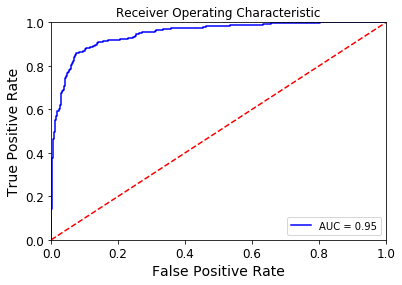

Saving figure Q2_1_ROC_curve_test


<Figure size 432x288 with 0 Axes>

In [12]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_curve, auc
accuracy = accuracy_score(ytest, ytilde, normalize=True)
error_rate = 1 - accuracy
print(error_rate)
print(confusion_matrix(ytest, ytilde))

fpr, tpr, thresholds = roc_curve(ytest, pestimate, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
save_fig("Q2_1_ROC_curve_test")

Saving figure Q2_2_precision_recall_vs_threshold_plot


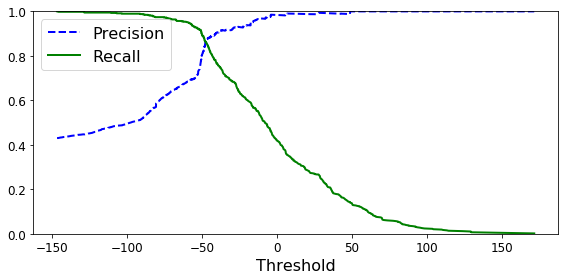

Optimal threshold is: -114.09780899569105


In [13]:
precisions, recalls, thresholds = precision_recall_curve(ytest, pestimate)

def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold", fontsize=16)
    plt.legend(loc="upper left", fontsize=16)
    plt.ylim([0, 1])

plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.xlim([-60, -10])
save_fig("Q2_2_precision_recall_vs_threshold_plot")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is: " + str(optimal_threshold))

Saving figure Q2_3_precision_vs_recall_plot


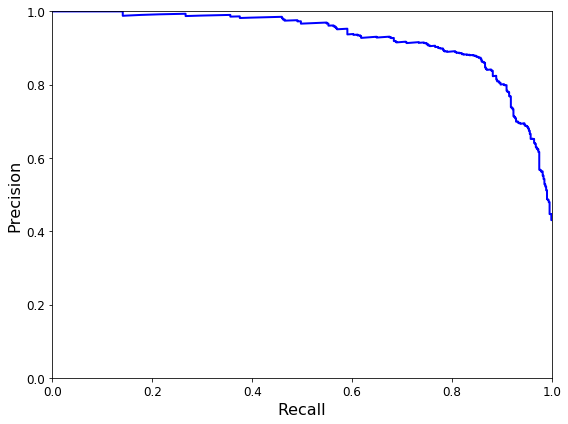

In [14]:
def plot_precision_vs_recall(precisions, recalls):
    plt.plot(recalls, precisions, "b-", linewidth=2)
    plt.xlabel("Recall", fontsize=16)
    plt.ylabel("Precision", fontsize=16)
    plt.axis([0, 1, 0, 1])

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("Q2_3_precision_vs_recall_plot")
plt.show()

0.4440456769983687


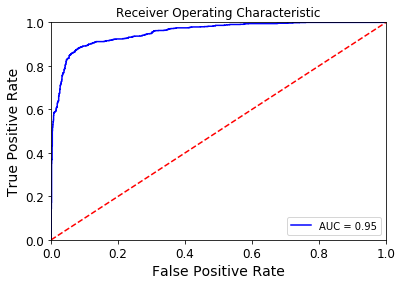

Saving figure Q2_4_ROC_curve_train


<Figure size 432x288 with 0 Axes>

In [15]:
ytilde = []
pestimate = []
for index, x in Xtrain.iterrows():
    p, yt = predict(parameters, x)
    ytilde.append(yt)
    pestimate.append(p)
accuracy = accuracy_score(ytrain, ytilde, normalize=True)
error_rate = 1 - accuracy
print(error_rate)

fpr, tpr, thresholds = roc_curve(ytrain, pestimate, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
save_fig("Q2_4_ROC_curve_train")

## Gaussian Naive Bayes: Log-transform

In [21]:
data = scipy.io.loadmat('spamData.mat')
Xtrain_total_np, Xtest_np, ytrain_total_np, ytest_np = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
Xtrain_total_raw, Xtest_raw, ytrain_total, ytest = pd.DataFrame(Xtrain_total_np), pd.DataFrame(Xtest_np), pd.DataFrame(ytrain_total_np), pd.DataFrame(ytest_np)
Xtrain_total_raw.shape

(3065, 57)

test error rate:  0.421875


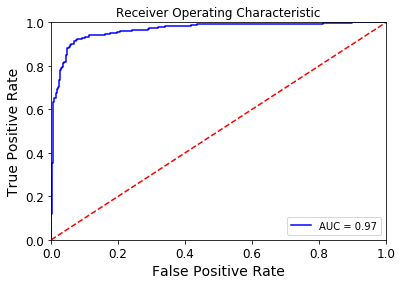

Saving figure Q2_5_ROC_curve_log_test
Saving figure Q2_6_precision_recall_vs_threshold_plot_log


<Figure size 432x288 with 0 Axes>

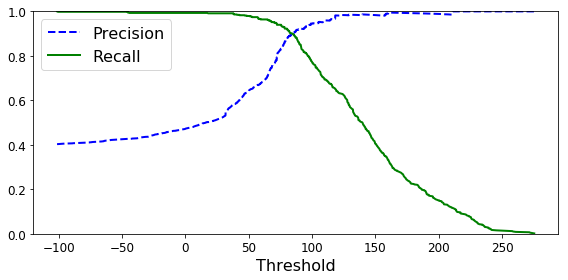

Optimal threshold is: -35.26870119345679
Saving figure Q2_7_precision_vs_recall_plot_log


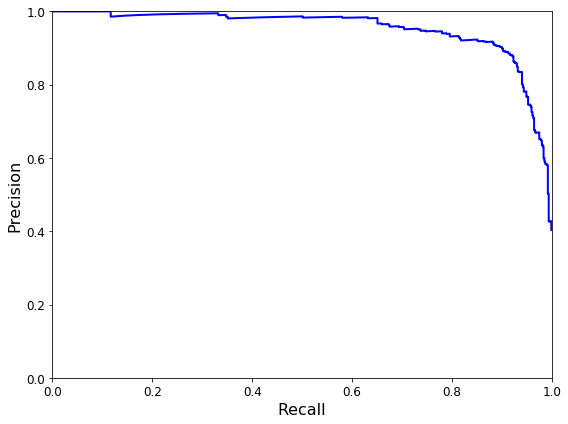

train error rate:  0.38890701468189237


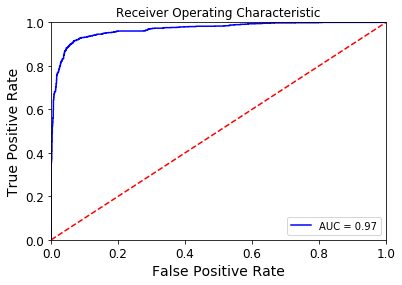

Saving figure Q2_8_ROC_curve_log_train


<Figure size 432x288 with 0 Axes>

In [22]:
Xtrain = preprocess(Xtrain_total_raw, "log-transform") # no need for validation since no hyperparameters
ytrain = ytrain_total
Xtest = preprocess(Xtest_raw, "log-transform")

Xtrain_spam, Xtrain_notSpam = split_on_class(Xtrain, ytrain)
parameters = np.empty((2, len(Xtrain.columns), 2)) # (class, feature, mean/std)
for i in range(len(Xtrain.columns)):
    parameters[0][i][0] = Xtrain_notSpam[i].mean()
    parameters[0][i][1] = Xtrain_notSpam[i].std()
    parameters[1][i][0] = Xtrain_spam[i].mean()
    parameters[1][i][1] = Xtrain_spam[i].std()

ytilde = []
pestimate = []
for index, x in Xtest.iterrows():
    p, yt = predict(parameters, x)
    ytilde.append(yt)
    pestimate.append(p)
accuracy = accuracy_score(ytest, ytilde, normalize=True)
error_rate = 1 - accuracy
print("test error rate: ", str(error_rate))

fpr, tpr, thresholds = roc_curve(ytest, pestimate, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
save_fig("Q2_5_ROC_curve_log_test")

precisions, recalls, thresholds = precision_recall_curve(ytest, pestimate)
plt.figure(figsize=(8, 4))
plot_precision_recall_vs_threshold(precisions, recalls, thresholds)
#plt.xlim([-60, -10])
save_fig("Q2_6_precision_recall_vs_threshold_plot_log")
plt.show()

optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print("Optimal threshold is: " + str(optimal_threshold))

plt.figure(figsize=(8, 6))
plot_precision_vs_recall(precisions, recalls)
save_fig("Q2_7_precision_vs_recall_plot_log")
plt.show()

ytilde = []
pestimate = []
for index, x in Xtrain.iterrows():
    p, yt = predict(parameters, x)
    ytilde.append(yt)
    pestimate.append(p)
accuracy = accuracy_score(ytrain, ytilde, normalize=True)
error_rate = 1 - accuracy
print("train error rate: ", str(error_rate))

fpr, tpr, thresholds = roc_curve(ytrain, pestimate, pos_label=1)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
save_fig("Q2_8_ROC_curve_log_train")

## Custom Gaussian Naive Bayes Class for future use
Here, we use a class to allow the above calculations to be done easily and systematically. This is a standalone class and does not require any of the above code to run.

In [18]:
from math import log
import numpy as np
import pandas as pd
from sklearn.base import BaseEstimator, TransformerMixin

eps = np.finfo(float).eps

class NaiveBayesGaussian(BaseEstimator, TransformerMixin):
    def __init__(self, preprocess="z-norm"):
        self.preprocess = preprocess
    
    def split_on_class(self, X, y):
        mask = y[0] == 1
        spam = X[mask]
        notSpam = X[~mask]
        return spam, notSpam
    
    def gaussianProb(self, x, mean, std):
        exponent = math.exp(-(math.pow(x-mean,2)/(2*math.pow(max(std,eps),2))))
        return (1 / (math.sqrt(2*math.pi) * (max(std,eps)))) * exponent
    
    def predict(self, parameters, x):
        probs = np.empty(2)
        probs[0] = log(1-lambda_ml)
        probs[1] = log(lambda_ml)
        for i in range(len(parameters[0])):
            probs[0] += log(max(self.gaussianProb(x[i], parameters[0][i][0], parameters[0][i][1]),eps))
            probs[1] += log(max(self.gaussianProb(x[i], parameters[1][i][0], parameters[1][i][1]),eps))
        return probs.argmax()
    
    def fit(self, X, y):
        X = preprocess(X, self.preprocess)
        X_spam, X_notSpam = split_on_class(X, y)
        self.parameters = np.empty((2, len(X.columns), 2)) # (class, feature, mean/std)
        for i in range(len(X.columns)):
            self.parameters[0][i][0] = X_notSpam[i].mean()
            self.parameters[0][i][1] = X_notSpam[i].std()
            self.parameters[1][i][0] = X_spam[i].mean()
            self.parameters[1][i][1] = X_spam[i].std()
        return self
    
    def transform(self, X):
        X = preprocess(X, self.preprocess)
        ytilde = []
        for index, x in X.iterrows():
            ytilde.append(self.predict(self.parameters, x))
        return ytilde

Just to confirm that the above class runs as expected, we repeat the calculation with z-normalization to compare results

In [19]:
data = scipy.io.loadmat('spamData.mat')
Xtrain_total_np, Xtest_np, ytrain_total_np, ytest_np = data['Xtrain'], data['Xtest'], data['ytrain'], data['ytest']
Xtrain_total_raw, Xtest_raw, ytrain_total, ytest = pd.DataFrame(Xtrain_total_np), pd.DataFrame(Xtest_np), pd.DataFrame(ytrain_total_np), pd.DataFrame(ytest_np)
Xtrain_total_raw.shape

classifier = NaiveBayesGaussian("z-norm")
classifier.fit(Xtrain_total_raw, ytrain_total)
ytilde = classifier.transform(Xtest_raw)
accuracy = accuracy_score(ytest, ytilde, normalize=True)
print(1 - accuracy)

0.22265625
